In [1]:
import os
import numpy as np
from sklearn import tree
import tensorflow.keras as kr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Plots style & size
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 10)

# Import csv file and load into data variable
filename="powerproduction.csv"

data = np.loadtxt(filename, delimiter=",", skiprows=1)

# Split numpy array into two arrays, a two dimensional array for x-values, and one dimensional for y-values.
x = data[:,[0]].reshape(-1)
y = (data[:,[1]]).reshape(-1)

In [3]:
# Create pandas dataframe with x and y values formatted 1-dimensionally
train = pd.DataFrame()
train['x'] = x
train['y'] = y

print(train)

          x    y
0     0.000  0.0
1     0.125  0.0
2     0.150  0.0
3     0.225  0.0
4     0.275  0.0
..      ...  ...
495  24.775  0.0
496  24.850  0.0
497  24.875  0.0
498  24.950  0.0
499  25.000  0.0

[500 rows x 2 columns]


Text(0, 0.5, 'Power')

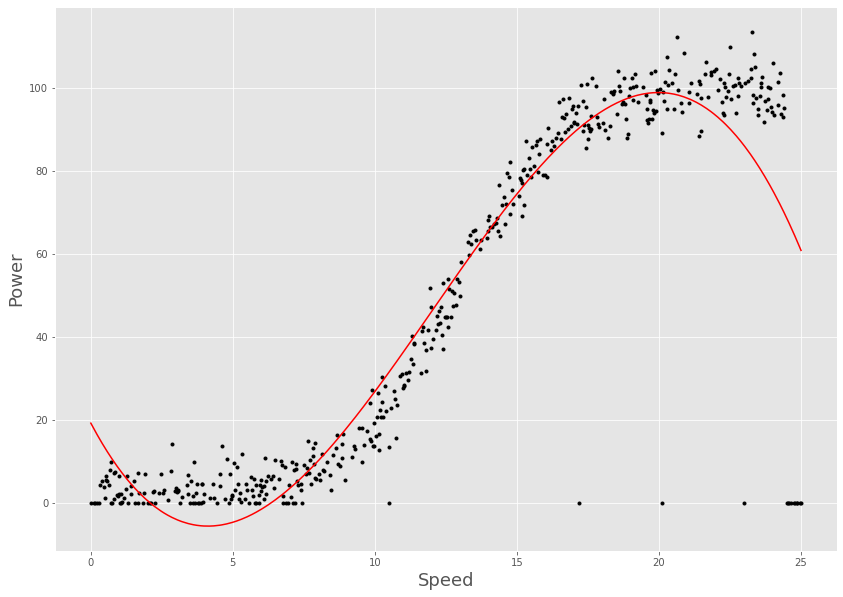

In [4]:
# Plot data for visualization
# The graph looks like a cubic function, f(x) = ax^3 + bx^2 + cx + d
a,b,c,d = np.polyfit(x, y, 3)
plt.plot(x, y, 'k.')
plt.plot(x, a * x * x * x + b * x * x + c * x + d, 'r-')
plt.xlabel("Speed", fontsize=18)
plt.ylabel("Power", fontsize=18)

## Enterpreting data according to the graph
When points are arranged in this type of pattern, and not randomly dispersed about the line, linear regression is not the best predictor for getting results.

According to an environmental research letter which discusses the topic of predicting turbine power output with wind speed, I quote, *The power output from the turbine is not a linear function of wind speed (figure 3), so, multivariate linear regression is not an appropriate technique. Non-linear regression assumes that the relationships are constant throughout the model space (i.e. power output is always proportional to Un), which from figure 3 is incorrect, so non-linear regression is also inappropriate. Also, multivariate bins only work where the training data includes data in all bins and so would be computationally or observationally more expensive. Instead, a technique is required that can capture non-linear changes in response to forcing. For this reason, we propose a machine learning technique called 'regression trees'*[1].

## Testing Linear Regression with Keras.
***

In [5]:
# Using keras neural network to try to predict values.
model = kr.models.Sequential()
model.add(kr.layers.Dense(1, input_shape=(1,), activation="linear", kernel_initializer='ones', bias_initializer='zeros'))
model.compile('adam', loss='mean_squared_error')

In [6]:
# Train network with our data
model.fit(train['x'], train['y'], batch_size=60, epochs=500, verbose=0)

In [7]:
model.evaluate(train['x'], train['y'], verbose=1)

16/16 [==============================] - 0s 467us/step - loss: 537.8522


537.8522338867188

In [8]:
# Predict values with model created with Keras
model.predict([1.5, 5.5, 10.5, 25, 30])

array([[  7.8901725],
       [ 23.077755 ],
       [ 42.062233 ],
       [ 97.117226 ],
       [116.10171  ]], dtype=float32)

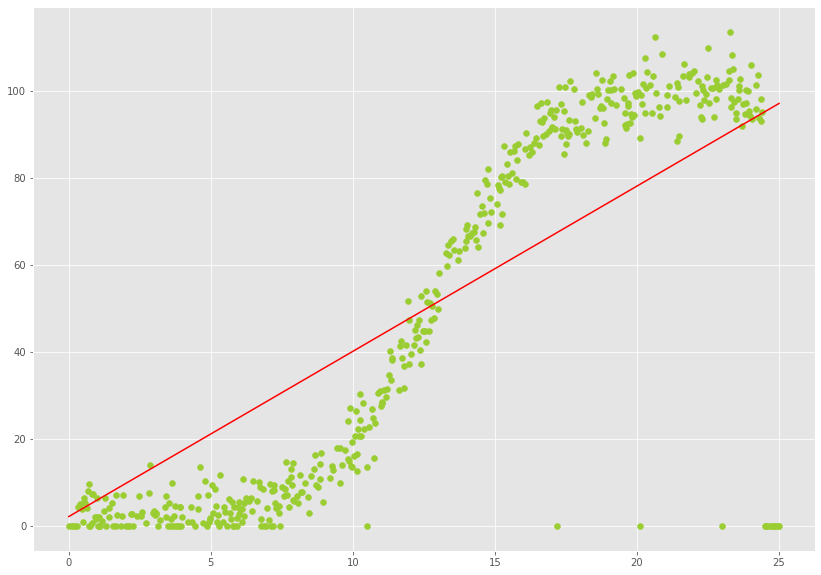

In [9]:
plt.scatter(x, y, color="yellowgreen")
plt.plot(x, model.predict(x), color="red")

***
## Testing Polynomial Regression with Keras
***

In [10]:
# Degree of curve
n = 3
# Expand dimensions of x
x_expanded = np.expand_dims(x, axis=1)
poly = PolynomialFeatures(n)

x_expanded = poly.fit_transform(x_expanded)

inp = kr.layers.Input((n+1)) 
#since one of the features is 1, we need an extra input
out = kr.layers.Dense(1)(inp)
model = kr.models.Model(inputs=inp, outputs=out)
model.compile(optimizer=kr.optimizers.Adam(lr=1e-3), loss="mean_squared_error")

In [11]:
model.fit(x_expanded, y, epochs=2000, verbose=0)

In [12]:
model.evaluate(x_expanded, y, verbose=1)

16/16 [==============================] - 0s 400us/step - loss: 280.7177


280.7177429199219

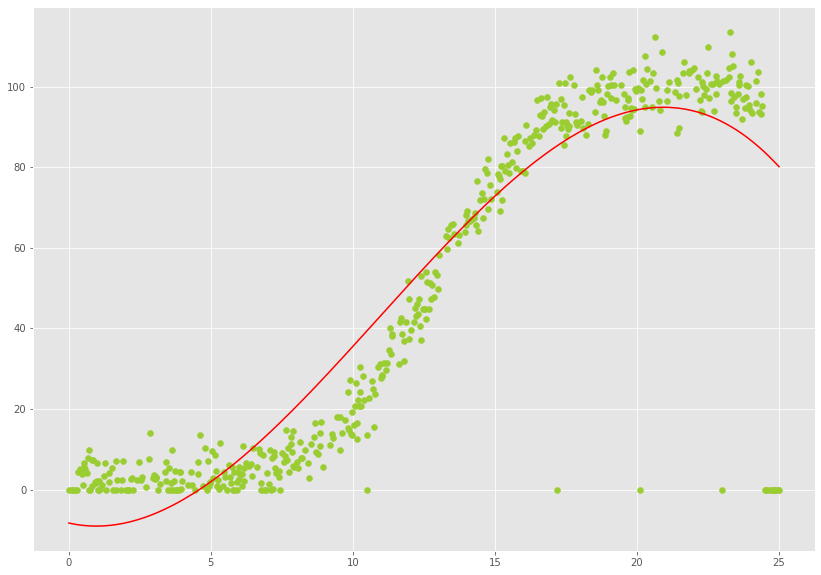

In [13]:
plt.scatter(x, y, color="yellowgreen")
plt.plot(x, model.predict(x_expanded), color="red")

In [14]:
test = [0, 5, 10, 15, 20]
test_expanded = np.expand_dims(test, axis=1)

test_expanded = poly.fit_transform(test_expanded)

model.predict(test_expanded)
#model.predict([1.5])

array([[-8.282301 ],
       [ 1.9770093],
       [35.548527 ],
       [72.829994 ],
       [94.21913  ]], dtype=float32)

## Results

The results obtained from linear regression predictions are obviously highly innacurate when trying to predict values that aren't a linear function. The results from the polynomial regression model generally still had a loss of >250. So I tried to find a decision tree model in the Keras documentation or StackOverflow. I decided to go with sci-kit learn's decision tree as it was still providing accurate results and is recommended by the Environmental reserarch letter[1].

***
## Decision Tree Testing and Research

In [15]:
# Decision tree model takes in a 2-Dimensional X variable and a 1-Dimensional y variable, so refactor X.
x = data[:,[0]]

# Comparing trees of different depth
tree_1 = tree.DecisionTreeRegressor(max_depth=2).fit(x, y)
tree_2 = tree.DecisionTreeRegressor(max_depth=13).fit(x, y)
tree_3 = tree.DecisionTreeRegressor(max_depth=20).fit(x, y)

In [20]:
# Predict values
X_test = np.arange(0.0, 25.0, 0.01)[:, np.newaxis]
y_1 = tree_1.predict(X_test)
y_2 = tree_2.predict(X_test)
y_3 = tree_3.predict(X_test)

pred1 = tree_1.predict([[0], [5], [10], [15], [20]])
pred2 = tree_2.predict([[0], [5], [10], [15], [20]])
pred3 = tree_3.predict([[0], [5], [10], [15], [20]])

print(pred1)
print(pred2)
print(pred3)

[ 6.35691866  6.35691866  6.35691866 88.39789958 88.39789958]
[ 0.          1.794      19.354      73.83733333 98.112     ]
[ 0.     1.681 19.354 73.911 98.79 ]


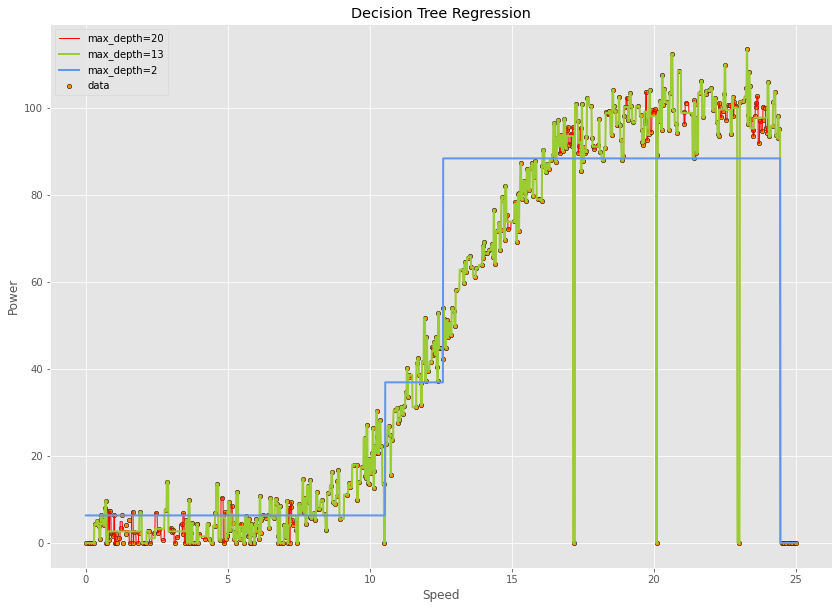

In [17]:
# Plot the results
plt.figure()
plt.plot(X_test, y_3, color="red", label="max_depth=20", linewidth=1)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=13", linewidth=2)
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.scatter(x, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.xlabel("Speed")
plt.ylabel("Power")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

## Results

*The decision trees is used to fit a sine curve with addition noisy observation. As a result, it learns local linear regressions approximating the sine curve.*

*We can see that if the maximum depth of the tree (controlled by the max_depth parameter) is set too high, the decision trees learn too fine details of the training data and learn from the noise, i.e. they overfit.*[2]

An example of an underfitted line would be the blue line, it doesn't have enough depth (depth=2) to make accurate predictions, as when given an input of 15 it returned 88, the actual output should have been ~75.

An overfitted line is the red line, it has a max depth of 20. It learns the noise of the data too well and will not deal well with new data.

A well-fitted line is the green line, with a max depth of 13, it returned an answer accurate to 1 decimal place and should deal well with new data.

## References

[1] Clifton, A., Kilcher, L., Lundquist, J.K. and Fleming, P., 2013. Using machine learning to predict wind turbine power output. Environmental research letters, 8(2), p.024009.  
[2] https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py  
[3] https://scikit-learn.org/stable/modules/tree.html#regression